In [56]:
import pandas as pd

raw = pd.read_csv('Cleaned data/steam_cleaned_less.csv')

## train dataset 80% for each gamer by time
train_raw=raw.groupby(['author.steamid']).apply(lambda x : x.sort_values(by = 'datetime_created', ascending = True).head(round(len(x)*0.8))).reset_index(drop = True)
train_raw[['author.steamid','datetime_created']].head(20)
## test dataset 20% for each gamer by time
test_raw=raw.groupby(['author.steamid']).apply(lambda x : x.sort_values(by = 'datetime_created', ascending = True).tail(round(len(x)*0.2))).reset_index(drop = True)
test_raw[['author.steamid','datetime_created']].head(20)

rating_map = {True: 1, False: 0}

apps = sorted(list(raw.app_id.unique()))
index_app_map = dict(zip(range(1, len(apps) + 1), apps))
app_index_map = dict(zip(apps, range(1, len(apps) + 1)))

users = list(raw['author.steamid'].unique())
index_user_map = dict(zip(range(1, len(users) + 1), users))
user_index_map = dict(zip(users, range(1, len(users) + 1)))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
def convert(data):
    df = data[['app_id', 'author.steamid', 'recommended']]
    df = df.dropna(how = 'any')
    df.columns = ['app_id', 'user_id', 'rating']

    df = df.replace({"app_id": app_index_map, "user_id": user_index_map, "rating": rating_map})
    
    return df

train = convert(train_raw)
test = convert(test_raw)

In [94]:
import scipy.sparse as sparse
import numpy as np

sparse_app_size = len(apps) + 1
sparse_user_size = len(users) + 1
train_mat = sparse.coo_matrix((train.rating.to_numpy(), (train.app_id.to_numpy(), train.user_id.to_numpy())),
                                 shape=(sparse_app_size, sparse_user_size), dtype=np.float64)
valid_mat = sparse.coo_matrix((valid.rating.to_numpy(), (valid.app_id.to_numpy(), valid.user_id.to_numpy())),
                                 shape=(sparse_app_size, sparse_user_size), dtype=np.float64)

sparse.save_npz('train_mat', train_mat)
sparse.save_npz('valid_mat', valid_mat)

In [98]:
from scipy.sparse.linalg import svds
import itertools
import numpy as np
import math
from collections import defaultdict
import time
import os
import datetime
from scipy import sparse
from matplotlib import pyplot as plt

def center_matrix_user(sparse_matrix, user_average):
    ix = 0
    num_apps = sparse_matrix.shape[0]
    num_users = sparse_matrix.shape[1]
    num_ratings = len(sparse_matrix.data)
    ratings = np.zeros((num_ratings))
    apps = np.zeros((num_ratings))
    users = np.zeros((num_ratings))

    # Create vectors of centered ratings
    for app, user, rating in zip(sparse_matrix.row, sparse_matrix.col, sparse_matrix.data):
        apps[ix] = app
        users[ix] = user
        ratings[ix] = rating - user_average[user]
        ix = ix + 1

    centered_matrix = sparse.coo_matrix((ratings, (apps, users)), shape=(num_apps, num_users), dtype=np.float64)

    return centered_matrix

# Latent Factor Model, courtesy to safreita1 and bsclayt1, excellent codes written
class LatentFactorModel:
    def __init__(self, epochs, k, learning_rate, lambda_reg):
        # Load the sparse matrix from a file
        self.training_filepath = 'train_mat.npz'
        self.testing_filepath = 'valid_mat.npz'
        self.training_coo = self.load_sparse_matrix(self.training_filepath)
        self.test_coo = self.load_sparse_matrix(self.testing_filepath)

        self.P = None
        self.Q = None
        self.epochs = epochs
        self.current_epoch = 0
        self.k = k
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.training_csc = None
        self.training_csr = None
        self.test_csc = None
        self.test_csr = None
        self.user_average = {}
        self.global_mean = 0.0
        self.training_rsmes = []
        self.testing_rsmes = []

        self.training_csc, self.training_csr = self.training_coo.tocsc(), self.training_coo.tocsr()
        self.test_csc, self.test_csr = self.test_coo.tocsc(), self.test_coo.tocsr()

        self.calculate_mean_user_rating()
        self.training_coo = center_matrix_user(sparse_matrix=self.training_coo, user_average=self.user_average)

        # Recalculate the CSC and CSR matrices after centering
        self.training_csc, self.training_csr = self.training_coo.tocsc(), self.training_coo.tocsr()
        self.test_csc, self.test_csr = self.test_coo.tocsc(), self.test_coo.tocsr()


    def load_sparse_matrix(self, file_name):
        return sparse.load_npz(file_name)

    def calculate_global_baseline_rating(self):
        summed_app_rating = 0
        for i, j, v in zip(self.training_coo.row, self.training_coo.col, self.training_coo.data):
            summed_app_rating = summed_app_rating + v

        number_of_ratings = self.training_coo.nnz
        self.global_mean = float(summed_app_rating) / number_of_ratings

    def calculate_mean_user_rating(self):
        self.calculate_global_baseline_rating()

        # Calculate the mean of each user
        user_sums = self.training_csc.sum(axis=0)
        # Reshape the matrix to array form for proper indexing
        user_sums = user_sums.reshape((user_sums.size, 1))
        # Calculate the number of ratings for each user
        user_rating_counts = self.training_csc.getnnz(axis=0)

        # Loop through each user
        number_of_users = self.training_csc.shape[1]
        for index in range(1, number_of_users):
            # Check to see if the user has not rated
            if user_sums[index] != 0:
                user_average = float(user_sums[index]) / user_rating_counts[index]
                self.user_average[index] = user_average
            else:
                self.user_average[index] = self.global_mean

    def run_svd(self):
        u, s, vt = svds(self.training_csc, k=self.k)

        self.Q = u
        diag_matrix = np.diag(s)
        self.P = diag_matrix.dot(vt)

    def predicted_value(self, app, user):
        col = self.P[:, user]
        row = self.Q[app, :]
        return row.dot(col)

    def error(self, app, user):
        actual_value = self.training_csr[app, user]
        predicted_value = self.predicted_value(app, user)
        return actual_value - predicted_value

    def square_error_train(self, app, user):
        actual_value = self.training_csr[app, user]
        predicted_value = self.predicted_value(app, user) + self.user_average[user]
        return math.pow(actual_value - predicted_value, 2)

    def square_error_test(self, app, user):
        actual_value = self.test_csr[app, user]
        predicted_value = self.predicted_value(app, user) + self.user_average[user]
        return math.pow(actual_value - predicted_value, 2)

    def calculate_test_rmse(self):
        summed_error = 0

        # Loop through each entry in the test dataset
        for app, user, true_rating in zip(self.test_coo.row, self.test_coo.col, self.test_coo.data):
            summed_error = summed_error + self.square_error_test(app, user)

        # Calculate the number of entries in the test set
        test_dataset_size = self.test_coo.nnz

        rmse = math.sqrt(float(summed_error) / test_dataset_size)

        return rmse

    def calculate_training_rmse(self):
        summed_error = 0

        # Loop through each entry in the test dataset
        for app, user, true_rating in zip(self.training_coo.row, self.training_coo.col, self.training_coo.data):
            summed_error = summed_error + self.square_error_train(app, user)

        # Calculate the number of entries in the test set
        training_dataset_size = self.training_coo.nnz

        rmse = math.sqrt(float(summed_error) / training_dataset_size)

        return rmse

    def calculate_epoch_error(self, epoch):
        start = time.time()
        rmse_test = self.calculate_test_rmse()
        end = time.time()
        print("Time to calculate RMSE test: {}".format(end - start))

        start = time.time()
        rmse_training = self.calculate_training_rmse()
        end = time.time()
        print("Time to calculate RMSE training: {}".format(end - start))
        
        self.training_rsmes.append(rmse_training)
        self.testing_rsmes.append(rmse_test)

        print("Training RMSE for epoch {}: {}".format(epoch, rmse_training))
        print("Test RMSE for epoch {}: {}".format(epoch, rmse_test))

        return rmse_test, rmse_training


    def optimize_matrices(self):
        for epoch in range(self.current_epoch, self.epochs):
            print()

            count = 0
            start = time.time()
            # Loop through each entry in the training dataset
            for app, user, true_rating in zip(self.training_coo.row, self.training_coo.col, self.training_coo.data):

                if count % 100000 == 0:
                    print( "Current count {}".format(count))
                    end = time.time()
                    print( "Time taken {}".format(end-start))
                    start = end
                count = count + 1

                # Loop through every latent factor
                for k in range(self.k):
                    error = 2 * self.error(app, user) * self.P[k, user]
                    regularization = - 2 * self.lambda_reg * self.Q[app, k]
                    gradient_q =  self.learning_rate * (error + regularization)
                    self.Q[app, k] = self.Q[app, k] + gradient_q

                    gradient_p = self.learning_rate * (2 * self.error(app, user) * self.Q[app, k] - 2 * self.lambda_reg * self.P[k, user])
                    self.P[k, user] = self.P[k, user] + gradient_p

                    # self.Q[app, k] = self.Q[app, k] + self.learning_rate * (2 * self.error(app, user) * self.P[k, user] - 2 * self.lambda_reg * self.Q[app, k])
                    # self.P[k, user] = self.P[k, user] + self.learning_rate * (2 * self.error(app, user) * self.Q[app, k] - 2 * self.lambda_reg * self.P[k, user])
            
            rmse_test, rmse_training = self.calculate_epoch_error(epoch)

    def fit(self):
        self.run_svd()
        self.optimize_matrices()

    def plot_history(self):
        plt.plot(range(self.epochs), self.training_rsmes, color='blue', label = 'Training RMSE')
        plt.plot(range(self.epochs), self.testing_rsmes, color='orange', label = 'Testing RMSE')
        plt.legend()
        plt.show()

In [104]:
k = 20
epochs = 10
learning_rate = 0.001
lambda_reg = 0.01

latent_model = LatentFactorModel(epochs=epochs, k=k, learning_rate=learning_rate, lambda_reg=lambda_reg)
latent_model.fit()
test_rmse = latent_model.calculate_test_rmse()
print( "Random split test RMSE is: " + str(test_rmse))


Current count 0
Time taken 0.0
Current count 100000
Time taken 108.51448059082031
Time to calculate RMSE test: 1.071791410446167
Time to calculate RMSE training: 4.574704647064209
Training RMSE for epoch 0: 0.879442685374889
Test RMSE for epoch 0: 0.25456352206057165

Current count 0
Time taken 0.0
Current count 100000
Time taken 108.02111792564392
Time to calculate RMSE test: 1.0519204139709473
Time to calculate RMSE training: 4.472766160964966
Training RMSE for epoch 1: 0.881138092692962
Test RMSE for epoch 1: 0.25783135899055526

Current count 0
Time taken 0.0
Current count 100000
Time taken 106.92349004745483
Time to calculate RMSE test: 1.038001298904419
Time to calculate RMSE training: 4.471024751663208
Training RMSE for epoch 2: 0.8824497293602721
Test RMSE for epoch 2: 0.2608531253070393

Current count 0
Time taken 0.0
Current count 100000
Time taken 106.59472727775574
Time to calculate RMSE test: 1.028998613357544
Time to calculate RMSE training: 4.4850592613220215
Training R

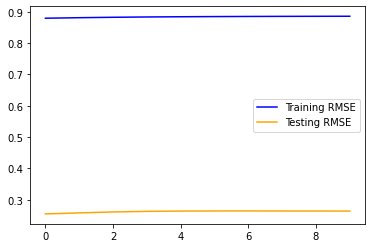

In [105]:
latent_model.plot_history()

In [106]:
infer = np.matmul(latent_model.Q, latent_model.P)
infer.shape

(137, 10526)

In [107]:
import random as random

random.seed(1234)

# user_eval = random.sample(range(1, len(users) + 1), math.floor(len(users) * 0.2))
user_eval = range(1, len(users) + 1)
print('test data shape ', test_raw.shape)

test_users = list(test_raw['author.steamid'].unique())
print('Number of testing user: ', len(test_users))

result = {} 
for uid in user_eval:
    user_id = index_user_map[uid]
    if user_id in test_users:
        recommended = np.argsort(infer[:, uid])[-10:]
        recommended = [index_app_map[x] for x in recommended]
        result[index_user_map[uid]] = recommended

print('Number of testing user: ', len(result.keys()))

with open('result.txt', 'w') as f:
    for key in result.keys():
        f.write("%s: %s\n"%(key, result[key]))

test_raw.head()

test data shape  (41007, 44)
Number of testing user:  10525
Number of testing user:  10525


,Unnamed: 0,review_id,review,app_id,app_name,url,author.steamid,recommended,votes_helpful,votes_funny,...,achievements,mature_content,minimum_requirements,recommended_requirements,recent_reviews_type,recent_reviews_number,recent_reviews_pct,all_reviews_type,all_reviews_number,all_reviews_pct
0,171894,49696198,a solid game I have never played any dark soul...,814380,Sekiro™: Shadows Die Twice,https://store.steampowered.com/app/814380/Seki...,76561197960270613,True,2,0,...,34.0,Mature Content Description The developers de...,"Minimum:,OS:,Windows 7 64-bit | Windows 8 64-b...","Recommended:,OS:,Windows 7 64-bit | Windows 8 ...",Very Positive,975.0,90.0,Very Positive,18.0,86.0
1,478144,50168721,Playing this game makes me want to drop everyt...,582160,Assassin's Creed Origins,https://store.steampowered.com/app/582160/Assa...,76561197960270613,True,1,0,...,67.0,NaN,"Minimum:,OS:,Windows 7 SP1, Windows 8.1, Windo...","Recommended:,OS:,Windows 7 SP1, Windows 8.1, W...",Mostly Positive,359.0,73.0,Very Positive,33.0,83.0
2,222339,50292984,❤️ ❤️ ❤️ ❤️ ❤️ ❤️ Love this game these little ...,424840,Little Nightmares,https://store.steampowered.com/app/424840/Litt...,76561197960270613,True,1,0,...,22.0,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",Very Positive,62.0,93.0,Very Positive,6.0,88.0
3,351122,50649038,I now sleep with a nightlight thank you outlas...,238320,Outlast,https://store.steampowered.com/app/238320/Outl...,76561197960270613,True,2,11,...,14.0,Mature Content Description The developers de...,"Minimum:,OS:,Windows XP / Vista / 7 / 8 - 64 b...","Recommended:,OS:,Windows Vista / 7 / 8 - 64 bi...",Very Positive,137.0,92.0,Overwhelmingly Positive,30.0,96.0
4,658073,48943716,The game seems cool and I intend to play more ...,107410,Arma 3,https://store.steampowered.com/app/107410/Arma_3/,76561197960271099,False,1,3,...,104.0,NaN,"Minimum:,OS:,Windows 7 SP1 (64bit),Processor:,...","Recommended:,OS:,Windows 7 / 8 / 10 (64bit),Pr...",Mostly Positive,870.0,78.0,Very Positive,81.0,89.0


In [108]:
raw.head()

,Unnamed: 0,review_id,review,app_id,app_name,url,author.steamid,recommended,votes_helpful,votes_funny,...,achievements,mature_content,minimum_requirements,recommended_requirements,recent_reviews_type,recent_reviews_number,recent_reviews_pct,all_reviews_type,all_reviews_number,all_reviews_pct
0,0,85174926,The game is enjoyable enough but...\n-Combat h...,292030,The Witcher 3: Wild Hunt,https://store.steampowered.com/app/292030/The_...,76561198020027165,True,0,0,...,78.0,Mature Content Description The developers de...,"Minimum:,OS:,64-bit Windows 7, 64-bit Windows ...","Recommended:,OS:,64-bit Windows 7, 64-bit Wind...",Overwhelmingly Positive,2.0,96.0,Overwhelmingly Positive,189.0,97.0
1,1,85165539,like dark souls but with witches,292030,The Witcher 3: Wild Hunt,https://store.steampowered.com/app/292030/The_...,76561198983515611,True,0,0,...,78.0,Mature Content Description The developers de...,"Minimum:,OS:,64-bit Windows 7, 64-bit Windows ...","Recommended:,OS:,64-bit Windows 7, 64-bit Wind...",Overwhelmingly Positive,2.0,96.0,Overwhelmingly Positive,189.0,97.0
2,3,85155206,They certainly dumbed down the series since th...,292030,The Witcher 3: Wild Hunt,https://store.steampowered.com/app/292030/The_...,76561198010955177,False,0,0,...,78.0,Mature Content Description The developers de...,"Minimum:,OS:,64-bit Windows 7, 64-bit Windows ...","Recommended:,OS:,64-bit Windows 7, 64-bit Wind...",Overwhelmingly Positive,2.0,96.0,Overwhelmingly Positive,189.0,97.0
3,14,85049145,⠀,292030,The Witcher 3: Wild Hunt,https://store.steampowered.com/app/292030/The_...,76561197969538443,True,0,0,...,78.0,Mature Content Description The developers de...,"Minimum:,OS:,64-bit Windows 7, 64-bit Windows ...","Recommended:,OS:,64-bit Windows 7, 64-bit Wind...",Overwhelmingly Positive,2.0,96.0,Overwhelmingly Positive,189.0,97.0
4,25,84841853,i mean the reviews say it all,292030,The Witcher 3: Wild Hunt,https://store.steampowered.com/app/292030/The_...,76561198173380217,True,1,0,...,78.0,Mature Content Description The developers de...,"Minimum:,OS:,64-bit Windows 7, 64-bit Windows ...","Recommended:,OS:,64-bit Windows 7, 64-bit Wind...",Overwhelmingly Positive,2.0,96.0,Overwhelmingly Positive,189.0,97.0


In [111]:

#rankedLlist: 预测的二维数组
#testList: test set的二维数组
#将传入两个数组的推荐人对应上，比如说rankedlist的第一个是user a，那么testList的第一个也要是user a
Hits_i = 0
Len_R = 0
Len_T = len(users)
MRR_i = 0
HR_i = 0
HR_i2 = 0
NDCG_i = 0    

count = test_raw.shape[0]
print(count)

for user_id in result.keys():
    rankedList = result[user_id]
    testList = list(test_raw[test_raw['author.steamid'] == user_id]['app_id'])
    for j in range(len(rankedList)):
        for k in range(len(testList)):
            if testList[k]==rankedList[j]:
                Hits_i+=1
                HR_i+=1
                HR_i2+=1
                MRR_i+=1/(j+1)   
                NDCG_i+=1/(math.log2(1+j+1))
                break
HR_i/=Len_T
HR_i2/=count
NDCG_i/=Hits_i
print(Hits_i)
print(f'HR_method1={HR_i}')
print(f'HR_method2={HR_i2}')
print(f'NDCG={NDCG_i}')

41007
2685
HR_method1=0.2551068883610451
HR_method2=0.06547662594191235
NDCG=0.4675681176778853
